In [1]:
cfg = {
    "texture_width": 256,
    "texture_height": 256,
    "texture_num_channels": 3,
    "batch_size": 1,
}

/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device cuda:0.


In [3]:
import sys
sys.path.insert(0, "../")

from functools import partial
import numpy as np
from tqdm import tqdm

import torch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
print(f"Using device {device}.")
import matplotlib.pyplot as plt


from models import ncsnpp
del ncsnpp
from models import utils as mutils
from losses import get_optimizer
from models.ema import ExponentialMovingAverage
from utils import restore_checkpoint
from configs.ve import ffhq_256_ncsnpp_continuous as configs
from sde_lib import VESDE
import datasets

ckpt_filename = "../exp/ve/ffhq_256_ncsnpp_continuous/checkpoint_48.pth"
config = configs.get_config()
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
sampling_eps = 1e-5
batch_size = 1
config.training.batch_size = batch_size
config.eval.batch_size = batch_size
random_seed = 0

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

def image_grid(x):
    size = config.data.image_size
    channels = config.data.num_channels
    img = x.reshape(-1, size, size, channels)
    w = int(np.sqrt(img.shape[0]))
    img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
    return img

def show_samples(x):
    x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
    img = image_grid(x)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(img)
    plt.show()


Using device cuda:0.


2022-05-27 10:41:21.662567: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [4]:
from pytorch3d.io import load_obj
from pytorch3d.renderer.mesh import Textures
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights,
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader
)

class Renderer(object):
    def __init__(self, device):
        self.raster_settings = RasterizationSettings(
            image_size=256,
            blur_radius=0.0,
            bin_size=0,
        )
        obj_path = "../assets/20705.obj"
        self.verts, self.faces, self.aux = load_obj(obj_path, device=device)
        self.verts_uvs = self.aux.verts_uvs[None, ...]  # (1, V, 2)
        self.faces_uvs = self.faces.textures_idx[None, ...]  # (1, F, 3)


    def render(self, texture, elev, azimuth):
        """
            Inputs:
                textures: torch.tensor with shape (N, C, H, W)
                elev: float
                azimuth: float
            Outputs:
                face images: (N, C, H, W)
        """

        texture = texture.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        tex = Textures(verts_uvs=self.verts_uvs, faces_uvs=self.faces_uvs, maps=texture)
        meshes = Meshes(verts=[self.verts], faces=[self.faces.verts_idx], textures=tex)
        verts_packed = meshes.verts_packed()
        center = verts_packed.mean(0)
        scale = max((verts_packed - center).abs().max(0)[0])
        meshes.offset_verts_(-center)
        meshes.scale_verts_((1.0 / float(scale)))
        R, T = look_at_view_transform(2.0, elev, azimuth)
        cameras = FoVPerspectiveCameras(R=R, T=T, device=device) # , znear=1, zfar=10000, fov=40, degrees=True, device=device)
        # lights = PointLights(diffuse_color=((0.7, 0.7, 0.7),), ambient_color=((0.2, 0.2, 0.2),), device=device, location=T)
        renderer = MeshRenderer(
            rasterizer=MeshRasterizer(
                cameras=cameras, 
                raster_settings=self.raster_settings
            ),
            shader=SoftPhongShader(
                device=device, 
                cameras=cameras,
                lights=None
            )
        )
        face = renderer(meshes)[:, :, :, :3].permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
        return face


In [63]:
# import cv2
# from PIL import Image

# obj_path = "../assets/20705.obj"
# verts, faces, aux = load_obj(obj_path, device=device)
# verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
# faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)
# tex_maps = aux.texture_images
# texture_image = list(tex_maps.values())[0][None, ...].to(device).permute(0, 3, 1, 2)
# renderer = Renderer()
# images = renderer.render(texture_image, 0, 0)
# image = Image.fromarray(np.array(images[0].detach().cpu().permute(1, 2, 0).numpy() * 255, dtype=np.uint8))
# display(image)



An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt
/local/home/aarslan/miniconda3/envs/score_face/lib/python3.9/site-packages/pytorch3d/io/utils.py:66: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")
100%|██████████| 1999/1999 [13:54<00:00,  2.39it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of function evaluations: 4000
Showing last face...


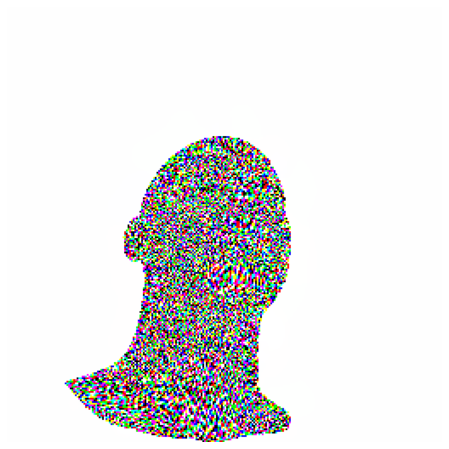

Showing last texture...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


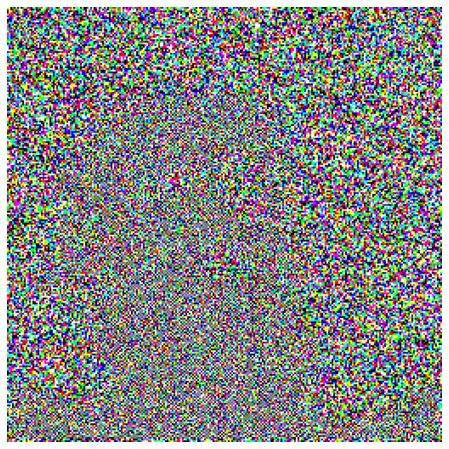

Showing new faces...


TypeError: render() missing 2 required positional arguments: 'elev' and 'azimuth'

In [6]:
from torch.autograd.functional import _as_tuple, _grad_preprocess, _check_requires_grad, _validate_v, _autograd_grad, _fill_in_zeros, _grad_postprocess, _tuple_postprocess


def vjp(func, inputs, score_fn, vec_t, create_graph=False, strict=False):
    r"""Function that computes the dot product between a vector ``v`` and the
    Jacobian of the given function at the point given by the inputs.

    Args:
        func (function): a Python function that takes Tensor inputs and returns
            a tuple of Tensors or a Tensor.
        inputs (tuple of Tensors or Tensor): inputs to the function ``func``.
        create_graph (bool, optional): If ``True``, both the output and result
            will be computed in a differentiable way. Note that when ``strict``
            is ``False``, the result can not require gradients or be
            disconnected from the inputs.  Defaults to ``False``.
        strict (bool, optional): If ``True``, an error will be raised when we
            detect that there exists an input such that all the outputs are
            independent of it. If ``False``, we return a Tensor of zeros as the
            vjp for said inputs, which is the expected mathematical value.
            Defaults to ``False``.

    Returns:
        output (tuple): tuple with:
            func_output (tuple of Tensors or Tensor): output of ``func(inputs)``

            vjp (tuple of Tensors or Tensor): result of the dot product with
            the same shape as the inputs.

    Example:

        >>> def exp_reducer(x):
        ...   return x.exp().sum(dim=1)
        >>> inputs = torch.rand(4, 4)
        >>> v = torch.ones(4)
        >>> vjp(exp_reducer, inputs, v)
        (tensor([5.7817, 7.2458, 5.7830, 6.7782]),
         tensor([[1.4458, 1.3962, 1.3042, 1.6354],
                [2.1288, 1.0652, 1.5483, 2.5035],
                [2.2046, 1.1292, 1.1432, 1.3059],
                [1.3225, 1.6652, 1.7753, 2.0152]]))

        >>> vjp(exp_reducer, inputs, v, create_graph=True)
        (tensor([5.7817, 7.2458, 5.7830, 6.7782], grad_fn=<SumBackward1>),
         tensor([[1.4458, 1.3962, 1.3042, 1.6354],
                [2.1288, 1.0652, 1.5483, 2.5035],
                [2.2046, 1.1292, 1.1432, 1.3059],
                [1.3225, 1.6652, 1.7753, 2.0152]], grad_fn=<MulBackward0>))

        >>> def adder(x, y):
        ...   return 2 * x + 3 * y
        >>> inputs = (torch.rand(2), torch.rand(2))
        >>> v = torch.ones(2)
        >>> vjp(adder, inputs, v)
        (tensor([2.4225, 2.3340]),
         (tensor([2., 2.]), tensor([3., 3.])))
    """

    with torch.enable_grad():
        is_inputs_tuple, inputs = _as_tuple(inputs, "inputs", "vjp")
        inputs = _grad_preprocess(inputs, create_graph=create_graph, need_graph=True)

        outputs = func(*inputs)
        with torch.no_grad():
            v = score_fn(x=outputs.detach(), t=vec_t).detach()
        is_outputs_tuple, outputs = _as_tuple(outputs, "outputs of the user-provided function", "vjp")
        _check_requires_grad(outputs, "outputs", strict=strict)

        if v is not None:
            _, v = _as_tuple(v, "v", "vjp")
            v = _grad_preprocess(v, create_graph=create_graph, need_graph=False)
            _validate_v(v, outputs, is_outputs_tuple)
        else:
            if len(outputs) != 1 or outputs[0].nelement() != 1:
                raise RuntimeError("The vector v can only be None if the "
                                   "user-provided function returns "
                                   "a single Tensor with a single element.")

    enable_grad = True if create_graph else torch.is_grad_enabled()
    with torch.set_grad_enabled(enable_grad):
        grad_res = _autograd_grad(outputs, inputs, v, create_graph=create_graph)
        vjp = _fill_in_zeros(grad_res, inputs, strict, create_graph, "back")

    # Cleanup objects and return them to the user
    outputs = _grad_postprocess(outputs, create_graph)
    vjp = _grad_postprocess(vjp, create_graph)

    return _tuple_postprocess(outputs, is_outputs_tuple), _tuple_postprocess(vjp, is_inputs_tuple)


def get_random_elev_azimuth():
    elev = (np.random.random() * 30) - 60
    azimuth = (np.random.random() * 30) - 60
    return elev, azimuth


def get_face_and_grad_texture(texture, elev, azimuth, score_fn, vec_t, renderer):
    render_partial = partial(renderer.render, elev=elev, azimuth=azimuth)
    face, grad_texture = vjp(func=render_partial, inputs=texture,
                             score_fn=score_fn, vec_t=vec_t,
                             create_graph=False, strict=False)
    return face, grad_texture


snr = 0.075	 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
continuous = config.training.continuous
eps = sampling_eps
device = config.device
denoise = True
score_fn = mutils.get_score_fn(sde, score_model, train=False, continuous=continuous)
renderer = Renderer(device=device)

timesteps = torch.linspace(sde.T, eps, sde.N, device=device)
t = timesteps[0]
vec_t = torch.ones(cfg["batch_size"], device=device) * t
# Initial sample
texture = torch.randn(size=(cfg["batch_size"], cfg["texture_num_channels"], cfg["texture_height"], cfg["texture_width"]), device=device, requires_grad=True)
elev, azimuth = get_random_elev_azimuth()
face, grad_texture = get_face_and_grad_texture(texture=texture, elev=elev, azimuth=azimuth, score_fn=score_fn, vec_t=vec_t, renderer=renderer)
face = face.detach()

rsde = sde.reverse(score_fn, probability_flow)
with torch.no_grad():
    for i in tqdm(list(range(1, sde.N))):
        t = timesteps[i]
        vec_t = torch.ones(cfg["batch_size"], device=device) * t
        alpha = torch.ones_like(vec_t)

        # langevin corrector
        for j in range(n_steps):
            # grad_face = score_fn(face, vec_t) # (N, C, H, W)
            noise_texture = torch.randn_like(texture)
            grad_norm = torch.norm(grad_texture.reshape(grad_texture.shape[0], -1), dim=-1).mean()
            noise_norm = torch.norm(noise_texture.reshape(noise_texture.shape[0], -1), dim=-1).mean()
            step_size = (snr * noise_norm / grad_norm) ** 2 * 2 * alpha
            texture_mean = texture + step_size[:, None, None, None] * grad_texture
            texture = (texture_mean + torch.sqrt(step_size * 2)[:, None, None, None] * noise_texture).detach()
            texture.requires_grad = True
            elev, azimuth = get_random_elev_azimuth()
            face, grad_texture = get_face_and_grad_texture(texture=texture, elev=elev, azimuth=azimuth, score_fn=score_fn, vec_t=vec_t, renderer=renderer)
            face = face.detach()

        # reverse diffusion predictor
        f, G = rsde.discretize(face, vec_t)
        z = torch.randn_like(face)
        face_mean = face - f
        face = face_mean + G[:, None, None, None] * z

    face = inverse_scaler(face_mean if denoise else face)
    texture = inverse_scaler(texture_mean if denoise else texture)
    print("Number of function evaluations:", sde.N * (n_steps + 1))

    print("Showing last face...")
    show_samples(face)

    print("Showing last texture...")
    show_samples(texture)

    print("Showing new faces...")
    show_samples(renderer.render(texture))
    show_samples(renderer.render(texture))
    show_samples(renderer.render(texture))



In [ ]:
def sample_face():
    img_size = config.data.image_size
    channels = config.data.num_channels
    shape = (batch_size, channels, img_size, img_size)
    snr = 0.075	 #@param {"type": "number"}
    n_steps = 1 #@param {"type": "integer"}
    probability_flow = False #@param {"type": "boolean"}
    continuous = config.training.continuous
    eps = sampling_eps
    device = config.device
    denoise = True

    with torch.no_grad():
        # Initial sample
        face = sde.prior_sampling(shape).to(device)
        timesteps = torch.linspace(sde.T, eps, sde.N, device=device)
        score_fn = get_score_fn(sde, score_model, train=False, continuous=continuous)
        rsde = sde.reverse(score_fn, probability_flow)

        for i in range(sde.N):
            t = timesteps[i]
            vec_t = torch.ones(shape[0], device=t.device) * t
            alpha = torch.ones_like(vec_t)

            # langevin corrector
            for i in range(n_steps):
                grad = score_fn(face, vec_t)
                noise = torch.randn_like(face)
                grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
                noise_norm = torch.norm(noise.reshape(noise.shape[0], -1), dim=-1).mean()
                step_size = (snr * noise_norm / grad_norm) ** 2 * 2 * alpha
                face_mean = face + step_size[:, None, None, None] * grad
                face = face_mean + torch.sqrt(step_size * 2)[:, None, None, None] * noise
            
            # reverse diffusion predictor
            f, G = rsde.discretize(face, vec_t)
            z = torch.randn_like(face)
            face_mean = face - f
            face = face_mean + G[:, None, None, None] * z

        face = inverse_scaler(face_mean if denoise else face)
        print("Number of function evaluations:", sde.N * (n_steps + 1))

    show_samples(face)



In [ ]:
sample_face()

In [ ]:
import numpy as np
import cv2
import torch
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
print(f"Using device {device}.")
from pytorch3d.io import load_obj
from pytorch3d.renderer.mesh import Textures
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader
)

import matplotlib.pyplot as plt
from PIL import Image

import sys
sys.path.append("../")
import datasets
import controllable_generation
from sde_lib import VESDE
from sampling import ReverseDiffusionPredictor, LangevinCorrector
from configs.ve import ffhq_256_ncsnpp_continuous as configs
from utils import restore_checkpoint
from models import utils as mutils
from models import ncsnpp
from models.ema import ExponentialMovingAverage
from losses import get_optimizer


In [ ]:
obj_path = "/cluster/scratch/aarslan/FFHQ/mesh_and_texture/03088.obj"
verts, faces, aux = load_obj(obj_path, device=device)
verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)
tex_maps = aux.texture_images
texture_image = list(tex_maps.values())[0]
texture_image = torch.randn_like(texture_image, device=device)[None, ...]

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, # 1024
    blur_radius=0.0,
    faces_per_pixel=5
)

# Place a point light in front of the object.
lights = PointLights(device=device, location=[[0.0, 0.0, 0.0]])

# for loop

tex = Textures(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image)
meshes = Meshes(verts=[verts], faces=[faces.verts_idx], textures=tex)

# We scale normalize and center the target mesh to fit in a sphere of radius 1 
# centered at (0,0,0). (scale, center) will be used to bring the predicted mesh 
# to its original center and scale.  Note that normalizing the target mesh, 
# speeds up the optimization but is not necessary!
verts_packed = meshes.verts_packed()
N = verts_packed.shape[0]
center = verts_packed.mean(0)
scale = max((verts_packed - center).abs().max(0)[0])
meshes.offset_verts_(-center)
meshes.scale_verts_((1.0 / float(scale)))

# Randomize dist, elev and azim parameters.
# With world coordinates +Y up, +X left and +Z in.
R, T = look_at_view_transform(dist=2.0, elev=0, azim=0.0)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

images = renderer(meshes)[:, :, :, :3].permute(0, 3, 1, 2)  # (N, C, H, W)
display(Image.fromarray((images[0].permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8)))




In [ ]:
img_size = config.data.image_size
channels = config.data.num_channels
shape = (batch_size, channels, img_size, img_size)
predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.16 #@param {"type": "number"}
n_steps =  1#@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
sampling_fn = sampling.get_pc_sampler(sde, shape, predictor, corrector,
                                      inverse_scaler, snr, n_steps=n_steps,
                                      probability_flow=probability_flow,
                                      continuous=config.training.continuous,
                                      eps=sampling_eps, device=config.device)

x, n = sampling_fn(score_model)
show_samples(x)

In [ ]:
"""
This code is from pl_bolts.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F


class UNet(nn.Module):
    """
    Paper: `U-Net: Convolutional Networks for Biomedical Image Segmentation
    <https://arxiv.org/abs/1505.04597>`_
    Paper authors: Olaf Ronneberger, Philipp Fischer, Thomas Brox
    Implemented by:
        - `Annika Brundyn <https://github.com/annikabrundyn>`_
        - `Akshay Kulkarni <https://github.com/akshaykvnit>`_
    Args:
        output_nc: Number of output classes required
        input_channels: Number of channels in input images (default 3)
        num_layers: Number of layers in each side of U-net (default 5)
        features_start: Number of features in first layer (default 64)
        bilinear: Whether to use bilinear interpolation or transposed convolutions (default) for upsampling.
    """

    def __init__(
            self,
            output_nc: int,
            input_channels: int = 3,
            num_layers: int = 5,
            features_start: int = 64,
            bilinear: bool = False
    ):
        super().__init__()
        self.num_layers = num_layers

        layers = [DoubleConv(input_channels, features_start)]

        feats = features_start
        for _ in range(num_layers - 1):
            layers.append(Down(feats, feats * 2))
            feats *= 2

        for _ in range(num_layers - 1):
            layers.append(Up(feats, feats // 2, bilinear))
            feats //= 2

        layers.append(nn.Conv2d(feats, output_nc, kernel_size=1))

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        xi = [self.layers[0](x)]
        # Down path
        for layer in self.layers[1:self.num_layers]:
            xi.append(layer(xi[-1]))
        # Up path
        for i, layer in enumerate(self.layers[self.num_layers:-1]):
            xi[-1] = layer(xi[-1], xi[-2 - i])
        x_out = self.layers[-1](xi[-1])
        return x_out


class DoubleConv(nn.Module):
    """
    [ Conv2d => BatchNorm (optional) => ReLU ] x 2
    """

    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.net(x)


class Down(nn.Module):
    """
    Downscale with MaxPool => DoubleConvolution block
    """

    def __init__(self, in_ch: int, out_ch: int):
        super().__init__()
        self.net = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            DoubleConv(in_ch, out_ch)
        )

    def forward(self, x):
        return self.net(x)


class Up(nn.Module):
    """
    Upsampling (by either bilinear interpolation or transpose convolutions)
    followed by concatenation of feature map from contracting path, followed by DoubleConv.
    """

    def __init__(self, in_ch: int, out_ch: int, bilinear: bool = False):
        super().__init__()
        self.upsample = None
        if bilinear:
            self.upsample = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                nn.Conv2d(in_ch, in_ch // 2, kernel_size=1),
            )
        else:
            self.upsample = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)

        # Pad x1 to the size of x2
        diff_h = x2.shape[2] - x1.shape[2]
        diff_w = x2.shape[3] - x1.shape[3]

        x1 = F.pad(x1, [diff_w // 2, diff_w - diff_w // 2, diff_h // 2, diff_h - diff_h // 2])

        # Concatenate along the channels axis
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


In [ ]:
import torch.nn as nn
from pl_bolts.models.autoencoders.components import (
    resize_conv1x1, resize_conv3x3
)


class ConditionedDecoderBlock(nn.Module):
    """
    ResNet block, but convs replaced with resize convs, and channel increase is in
    second conv, not first.
    Also heavily borrowed from pl_bolts.models.autoencoders.components.
    """

    expansion = 1

    def __init__(self, inplanes, planes, scale=1, upsample=None, condition_dim=16):
        super().__init__()
        self.conv1 = resize_conv3x3(inplanes + condition_dim,
                                    inplanes)  # 2 is the feature dimension for the conditioning
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = resize_conv3x3(inplanes, planes, scale)
        self.bn2 = nn.BatchNorm2d(planes)
        self.upsample = upsample

        self.interpolation_mode = "bilinear"

    def forward(self, data):
        x = data["features"]
        condition = data["condition"]

        condition_scaled = nn.functional.interpolate(condition, x.shape[-2:], mode=self.interpolation_mode)
        identity = x

        out = torch.cat([x, condition_scaled], 1)  # Along the channel dimension
        out = self.conv1(out)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.upsample is not None:
            identity = self.upsample(x)

        out += identity
        out = self.relu(out)

        out_dict = {"features": out, "condition": condition}
        return out_dict


class EarlyConditionedSimpleResNetDecoder(nn.Module):
    """
    Modified from pl_bolts.models.autoencoders.components.
    """

    def __init__(self, block, layers, latent_dim, input_height, nc_texture, first_conv=False, maxpool1=False,
                 condition_dim=16, **kwargs):
        # TODO: refactor duplicated code
        super().__init__()

        self.condition_dim = condition_dim

        self.expansion = block.expansion
        self.inplanes = 512 * block.expansion
        self.first_conv = first_conv
        self.maxpool1 = maxpool1
        self.input_height = input_height

        self.linear = nn.Linear(latent_dim, self.inplanes)

        self.initial = self._make_layer(block, 512, layers[0], scale=2, condition_dim=self.condition_dim)

        self.layer0 = self._make_layer(block, 256, layers[0], scale=2, condition_dim=self.condition_dim)
        self.layer1 = self._make_layer(block, 256, layers[0], scale=2, condition_dim=self.condition_dim)
        self.layer2 = self._make_layer(block, 128, layers[1], scale=2, condition_dim=self.condition_dim)
        self.layer3 = self._make_layer(block, 64, layers[2], scale=2, condition_dim=self.condition_dim)

        if self.input_height == 128:
            self.layer4 = self._make_layer(block, 64, layers[3], condition_dim=self.condition_dim)
        elif self.input_height == 256:
            self.layer4 = self._make_layer(block, 64, layers[3], scale=2, condition_dim=self.condition_dim)
        else:
            raise Warning("Invalid input height: '{}".format(self.input_height))

        if self.first_conv:
            self.upscale = Interpolate(scale_factor=2)
            self.upscale_factor *= 2

        self.conv1 = nn.Conv2d(
            64 * block.expansion, nc_texture, kernel_size=3, stride=1, padding=1, bias=False
        )

    def _make_layer(self, block, planes, blocks, scale=1, condition_dim=16):
        """
        Args:
            block:
            planes: int number of channels
            blocks: int number of blocks (e.g. 2)
            scale:
        Returns:
        """
        upsample = None
        if scale != 1 or self.inplanes != planes * block.expansion:
            upsample = nn.Sequential(
                resize_conv1x1(self.inplanes, planes * block.expansion, scale),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, scale, upsample, condition_dim=condition_dim))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, condition_dim=condition_dim))

        return nn.Sequential(*layers)

    def forward(self, x, condition):
        x = self.linear(x)
        # We now have 512 feature maps with the same value in all spatial locations
        # self.inplanes changes when creating blocks
        x = x.view(x.shape[0], 512, 1, 1).expand(-1, -1, 4, 4)

        in_dict = {"features": x, "condition": condition}
        out_dict = self.initial(in_dict)

        out_dict = self.layer0(out_dict)
        out_dict = self.layer1(out_dict)
        out_dict = self.layer2(out_dict)
        out_dict = self.layer3(out_dict)
        out_dict = self.layer4(out_dict)
        x = out_dict['features']
        x = self.conv1(x)
        return x


class AdditiveDecoder(nn.Module):
    """
    Additive decoder. Produces the additive feature image.
    Adapted from https://github.com/mcbuehler/VariTex/blob/385745548ddb0b770b9bc3f4c8716402fe0e245a/varitex/modules/decoder.py
    """

    def __init__(self, cfg):
        super().__init__()
        latent_dim_additive = cfg["latent_dim_additive"]
        input_height = cfg["image_height"]
        out_dim = cfg["num_channels"]
        condition_dim = cfg["num_channels"]  # We condition on a neural texture for the face interior
        # Resnet-18 variant
        self.decoder = EarlyConditionedSimpleResNetDecoder(ConditionedDecoderBlock, [2, 2, 2, 2], latent_dim_additive,
                                                            input_height, nc_texture=out_dim,
                                                            condition_dim=condition_dim)

    def forward(self, rendered_images, latent_vectors):
        """
            Inputs:
                rendered_images: (N, cfg["num_channels"], H, W)
                latent_vectors: (N, latent_dim_additive)
            
            Output:
                additive_feature_images: (N, cfg["num_channels"], H, W)
        """

        # The sampled texture should already have been masked to the face interior
        # Errors should not back-propagate through the sampled face interior texture
        additive_feature_images = self.decoder(latent_vectors, rendered_images.detach())
        return additive_feature_images

additive_decoder = AdditiveDecoder(cfg).to(device)


In [ ]:
class Feature2ImageRenderer(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.unet = UNet(output_nc=cfg["num_channels"], input_channels=cfg["num_channels"] * 2, features_start=cfg["nc_feature2image"],
                         num_layers=cfg["feature2image_num_layers"])

    def forward(self, concatted_images):
        return self.unet(concatted_images)

feature_to_image_renderer = Feature2ImageRenderer(cfg).to(device)


In [ ]:
latent_vectors = torch.randn(size=(cfg["batch_size"], cfg["latent_dim_additive"]), device=device)
additive_feature_images = additive_decoder(images, latent_vectors)
concatted_images = torch.concat([images, additive_feature_images], axis=1)
filled_images = feature_to_image_renderer(concatted_images)


In [ ]:
Image.fromarray((filled_images[0].permute(1, 2, 0).detach().cpu().numpy() * 255).astype(np.uint8))

In [ ]:
ckpt_filename = "../exp/ve/ffhq_256_ncsnpp_continuous/checkpoint_48.pth"
config = configs.get_config()
sde = VESDE(sigma_min=config.model.sigma_min, sigma_max=config.model.sigma_max, N=config.model.num_scales)
sampling_eps = 1e-5

batch_size = 1 #@param {"type":"integer"}
config.training.batch_size = batch_size
config.eval.batch_size = batch_size

random_seed = 0 #@param {"type": "integer"}

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

def image_grid(x):
    size = config.data.image_size
    channels = config.data.num_channels
    img = x.reshape(-1, size, size, channels)
    w = int(np.sqrt(img.shape[0]))
    img = img.reshape((w, w, size, size, channels)).transpose((0, 2, 1, 3, 4)).reshape((w * size, w * size, channels))
    return img


def show_samples(x):
    x = x.permute(0, 2, 3, 1).detach().cpu().numpy()
    img = image_grid(x)
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(img)
    plt.show()

predictor = ReverseDiffusionPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = LangevinCorrector #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.075 #@param {"type": "number"}
n_steps = 1 #@param {"type": "integer"}
probability_flow = False #@param {"type": "boolean"}
inverse_scaler = datasets.get_data_inverse_scaler(config)

pc_inpainter = controllable_generation.get_pc_inpainter(sde,
                                                        predictor,
                                                        corrector,
                                                        inverse_scaler,
                                                        snr=snr,
                                                        n_steps=n_steps,
                                                        probability_flow=probability_flow,
                                                        continuous=config.training.continuous,
                                                        denoise=True)

show_samples(images)
show_samples(images * masks)
inpainted_images = pc_inpainter(score_model, scaler(images), masks)
show_samples(inpainted_images)
